# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV

In [2]:
data_dir = "structured"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, "d1m_all_concat.csv")
df = pd.read_csv(csv_file)
print('Total:',len(df))
df.head()

Total: 74250


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-100.000000,-100.000000,-100.000000,-1.623506,-0.400301,1.031005,-35,-10,-10,-14,...,-100.000000,-100.000000,-100.000000,-100.000000,0.145592,-0.748738,0.053011,-0.009359,-0.224538,0.006875
1,-1.099158,-0.369425,1.014941,-1.368914,-0.384130,1.023165,-35,-10,-10,-12,...,0.048337,-0.055445,-0.225083,-0.023677,0.145440,-0.671699,0.054818,-0.009728,-0.222801,0.005612
2,-0.973916,-0.359220,1.011065,-1.191411,-0.372450,1.017727,-35,-10,-10,-10,...,0.049793,-0.061641,-0.222636,-0.024704,0.145270,-0.609372,0.055534,-0.006290,-0.221827,0.009013
3,-0.885849,-0.352547,1.008341,-1.068867,-0.364482,1.013952,-35,-10,-10,-8,...,0.051783,-0.060025,-0.226899,-0.025049,0.145427,-0.557835,0.056918,-0.005671,-0.220099,0.009754
4,-0.811432,-0.348102,1.006101,-0.952948,-0.357174,1.010446,-35,-10,-10,-6,...,0.054780,-0.061359,-0.225216,-0.024614,0.144297,-0.501951,0.058625,-0.005585,-0.219911,0.009287


In [3]:
# Filtered df
temp_df = df[~df.isin([-100.0]).any(axis=1)]
valid_df = temp_df[~temp_df.isin([-180.17578125]).any(axis=1)]
valid_df = valid_df.reset_index(drop=True)
print('Valid:',len(valid_df))
print('Removed:', len(df)-len(valid_df))
valid_df.head()

Valid: 71807
Removed: 2443


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-1.099158,-0.369425,1.014941,-1.368914,-0.384130,1.023165,-35,-10,-10,-12,...,0.048337,-0.055445,-0.225083,-0.023677,0.145440,-0.671699,0.054818,-0.009728,-0.222801,0.005612
1,-0.973916,-0.359220,1.011065,-1.191411,-0.372450,1.017727,-35,-10,-10,-10,...,0.049793,-0.061641,-0.222636,-0.024704,0.145270,-0.609372,0.055534,-0.006290,-0.221827,0.009013
2,-0.885849,-0.352547,1.008341,-1.068867,-0.364482,1.013952,-35,-10,-10,-8,...,0.051783,-0.060025,-0.226899,-0.025049,0.145427,-0.557835,0.056918,-0.005671,-0.220099,0.009754
3,-0.811432,-0.348102,1.006101,-0.952948,-0.357174,1.010446,-35,-10,-10,-6,...,0.054780,-0.061359,-0.225216,-0.024614,0.144297,-0.501951,0.058625,-0.005585,-0.219911,0.009287
4,-0.731786,-0.342917,1.003678,-0.845624,-0.350762,1.007190,-35,-10,-10,-4,...,0.057855,-0.060112,-0.223409,-0.022845,0.144394,-0.445641,0.061116,-0.004281,-0.218231,0.010852


In [4]:
# IQP Outlier Removal

cols = ['l_rvec_0','l_rvec_1','l_rvec_2','l_tvec_0','l_tvec_1','l_tvec_2',
        'r_rvec_0','r_rvec_1','r_rvec_2','r_tvec_0','r_tvec_1','r_tvec_2']

for col in cols:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = valid_df[col].quantile(0.25)
    Q3 = valid_df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    valid_df = valid_df[(valid_df[col] >= lower_bound) & (valid_df[col] <= upper_bound)]

print(valid_df.shape)
valid_df.head()

(70065, 32)


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-1.099158,-0.369425,1.014941,-1.368914,-0.384130,1.023165,-35,-10,-10,-12,...,0.048337,-0.055445,-0.225083,-0.023677,0.145440,-0.671699,0.054818,-0.009728,-0.222801,0.005612
1,-0.973916,-0.359220,1.011065,-1.191411,-0.372450,1.017727,-35,-10,-10,-10,...,0.049793,-0.061641,-0.222636,-0.024704,0.145270,-0.609372,0.055534,-0.006290,-0.221827,0.009013
2,-0.885849,-0.352547,1.008341,-1.068867,-0.364482,1.013952,-35,-10,-10,-8,...,0.051783,-0.060025,-0.226899,-0.025049,0.145427,-0.557835,0.056918,-0.005671,-0.220099,0.009754
3,-0.811432,-0.348102,1.006101,-0.952948,-0.357174,1.010446,-35,-10,-10,-6,...,0.054780,-0.061359,-0.225216,-0.024614,0.144297,-0.501951,0.058625,-0.005585,-0.219911,0.009287
4,-0.731786,-0.342917,1.003678,-0.845624,-0.350762,1.007190,-35,-10,-10,-4,...,0.057855,-0.060112,-0.223409,-0.022845,0.144394,-0.445641,0.061116,-0.004281,-0.218231,0.010852


In [5]:
# Filtered df
filtered_df = valid_df.reset_index(drop=True)
print("Final:",len(filtered_df))
print("Removed:",len(df)-len(filtered_df))
filtered_df.head()

Final: 70065
Removed: 4185


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-1.099158,-0.369425,1.014941,-1.368914,-0.384130,1.023165,-35,-10,-10,-12,...,0.048337,-0.055445,-0.225083,-0.023677,0.145440,-0.671699,0.054818,-0.009728,-0.222801,0.005612
1,-0.973916,-0.359220,1.011065,-1.191411,-0.372450,1.017727,-35,-10,-10,-10,...,0.049793,-0.061641,-0.222636,-0.024704,0.145270,-0.609372,0.055534,-0.006290,-0.221827,0.009013
2,-0.885849,-0.352547,1.008341,-1.068867,-0.364482,1.013952,-35,-10,-10,-8,...,0.051783,-0.060025,-0.226899,-0.025049,0.145427,-0.557835,0.056918,-0.005671,-0.220099,0.009754
3,-0.811432,-0.348102,1.006101,-0.952948,-0.357174,1.010446,-35,-10,-10,-6,...,0.054780,-0.061359,-0.225216,-0.024614,0.144297,-0.501951,0.058625,-0.005585,-0.219911,0.009287
4,-0.731786,-0.342917,1.003678,-0.845624,-0.350762,1.007190,-35,-10,-10,-4,...,0.057855,-0.060112,-0.223409,-0.022845,0.144394,-0.445641,0.061116,-0.004281,-0.218231,0.010852


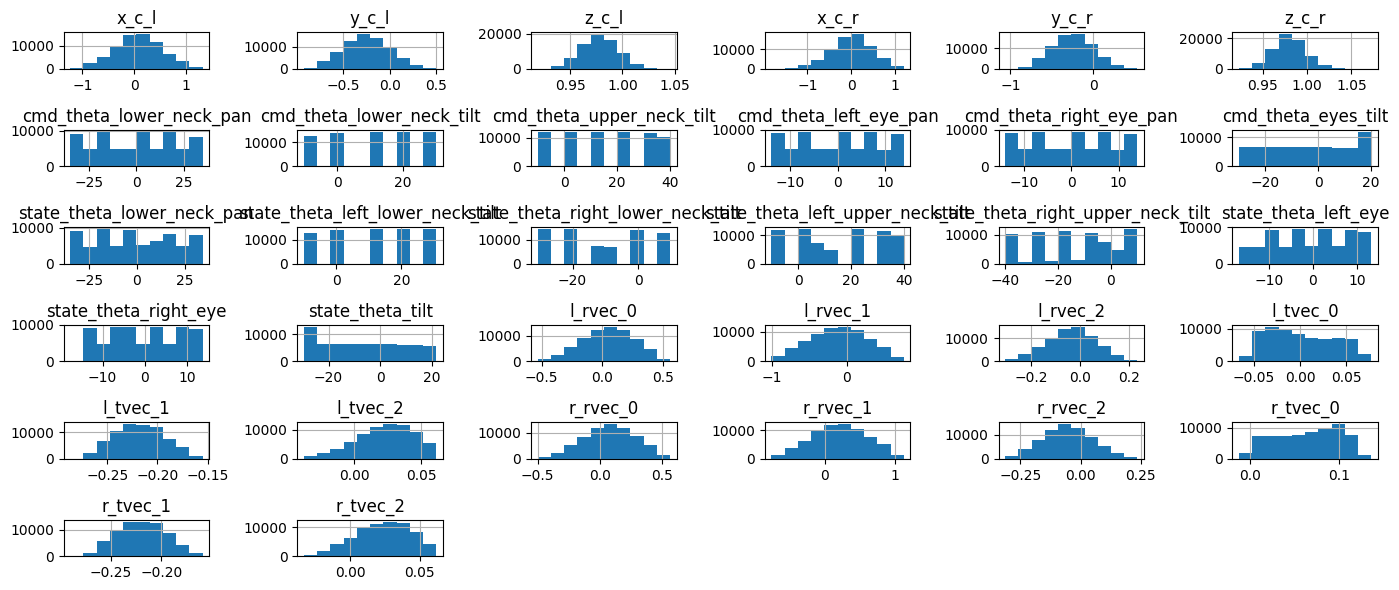

In [6]:
filtered_df.hist(figsize=(14,6))
plt.tight_layout()
plt.show()

# Inverse the Pose

## Left Eye Camera

In [7]:
# Getting the Data
left_data_arr = filtered_df[['l_rvec_0','l_rvec_1','l_rvec_2',
                                 'l_tvec_0','l_tvec_1','l_tvec_2']].to_numpy()
print(left_data_arr.shape)

(70065, 6)


In [8]:
# Computation
left_rvec_tvec_list = []
for i in range(left_data_arr.shape[0]):
    temp_arr = np.eye(4)
    rot_mat, _ = cv2.Rodrigues(left_data_arr[i,:3])
    temp_arr[:3,:3] = rot_mat
    temp_arr[:3,3] = left_data_arr[i,3:]
    inv_arr = np.linalg.inv(temp_arr)
    l_rvec,_ = cv2.Rodrigues(inv_arr[:3,:3])
    l_rvec_tvec = np.concatenate([l_rvec.flatten(), inv_arr[:3,3].flatten()])
    left_rvec_tvec_list.append(l_rvec_tvec)
left_rvec_tvec_arr = np.array(left_rvec_tvec_list)
print(left_rvec_tvec_arr.shape)

(70065, 6)


## Right Eye Camera

In [9]:
# Getting the Data
right_data_arr = filtered_df[['r_rvec_0','r_rvec_1','r_rvec_2',
                                   'r_tvec_0','r_tvec_1','r_tvec_2']].to_numpy()
print(right_data_arr.shape)

(70065, 6)


In [10]:
# Computation
right_rvec_tvec_list = []
for i in range(right_data_arr.shape[0]):
    temp_arr = np.eye(4)
    rot_mat, _ = cv2.Rodrigues(right_data_arr[i,:3])
    temp_arr[:3,:3] = rot_mat
    temp_arr[:3,3] = right_data_arr[i,3:]
    inv_arr = np.linalg.inv(temp_arr)
    r_rvec,_ = cv2.Rodrigues(inv_arr[:3,:3])
    r_rvec_tvec = np.concatenate([r_rvec.flatten(), inv_arr[:3,3].flatten()])
    right_rvec_tvec_list.append(r_rvec_tvec)
right_rvec_tvec_arr = np.array(right_rvec_tvec_list)
print(right_rvec_tvec_arr.shape)

(70065, 6)


## Changing the Values in the DataFrame

In [11]:
saved_df = filtered_df.copy()

saved_df['l_rvec_0'] = left_rvec_tvec_arr[:,0]
saved_df['l_rvec_1'] = left_rvec_tvec_arr[:,1]
saved_df['l_rvec_2'] = left_rvec_tvec_arr[:,2]
saved_df['l_tvec_0'] = left_rvec_tvec_arr[:,3]
saved_df['l_tvec_1'] = left_rvec_tvec_arr[:,4]
saved_df['l_tvec_2'] = left_rvec_tvec_arr[:,5]

saved_df['r_rvec_0'] = right_rvec_tvec_arr[:,0]
saved_df['r_rvec_1'] = right_rvec_tvec_arr[:,1]
saved_df['r_rvec_2'] = right_rvec_tvec_arr[:,2]
saved_df['r_tvec_0'] = right_rvec_tvec_arr[:,3]
saved_df['r_tvec_1'] = right_rvec_tvec_arr[:,4]
saved_df['r_tvec_2'] = right_rvec_tvec_arr[:,5]

# Saving the Final CSV

In [12]:
data_dir = 'final'
filepath = os.path.join(os.getcwd(),"..","data", data_dir, "241004_1m_grace_dataset.csv")
saved_df.to_csv(filepath, index=False)
print('Saved to:', filepath)

Saved to: /home/jaynieles/dev/grace_dl/notebooks/../data/final/241004_1m_grace_dataset.csv
